# Online Joint State and Parameters Estimation for AR SSM 
State space model
\begin{align*}
    &\mathbf{x}_t = \mathbf{A}\mathbf{x}_{t-1} + \mathbf{p}_t \quad \mathbf{p}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t + m_t \quad v_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_t\,|\,\mathbf{x}_{t-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_t\;\middle|\; \mathbf{A}\mathbf{x}_{t-1},  \mathbf{I}\gamma_x^{-1} \right)\\
    &p(y_t\,|\,\mathbf{x}_{t}) = \mathcal{N}\left(y_t \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_t, \gamma_y^{-1} \right)
\end{align*}

where
\begin{align*}
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

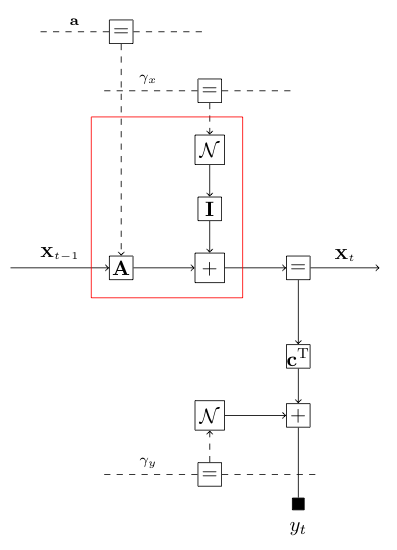

In [226]:
using Images
img = load("../ffgs/HAR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$, precision of process noise $\gamma_x$ and states $\mathbf{x}_n$, while setting measurement noise precisions $\gamma_y=1$.

In [672]:
using ProgressMeter
using Revise
using ForneyLab
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
include( "../AR-node/observationAR.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data, generate_sin
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [673]:
ARorder = 2 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# AR data
a = 1.0; b = 1.0
γ_x = b/a # process noise variance
#coefs, x = generate_data(1000, ARorder, 1.0, noise_variance=γ_x^-1)
x = use_data("../data/temperature.csv", ARorder)
coefs, x = generate_sin(1000, tiny)
γ_y = 1.0 # measurement noise precision
# Observations
xreal = [xi[1] for xi in x[ARorder:end]]
y = [xi[1] + sqrt(γ_y)^-1*randn() for xi in x[ARorder:end]]

999-element Array{Float64,1}:
 -1.4144158346700129  
  0.5984965716784761  
 -1.2410093395173367  
 -0.6792165359659493  
  2.3428890526900874  
  0.6342255794475117  
 -0.07220444688049144 
 -1.3658630387307547  
 -2.3068492893518364  
 -1.5751931067075624  
  0.008007048237698378
  2.027595469171949   
 -0.7417275358197852  
  ⋮                   
 -1.839338101441224   
 -2.2611402613046767  
 -0.934601219149194   
  1.3702994960020813  
  0.7001476983093148  
  1.2962543408208707  
 -1.4396235677491314  
 -2.301772065814156   
 -1.42293343519008    
 -1.3683757153367175  
  0.840509772109018   
  1.1549723481907481  

In [674]:
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a
@RV w_a
@RV m_y_t
@RV w_y_t
@RV a_w
@RV b_w

@RV a ~ GaussianMeanPrecision(m_a, w_a)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w, b_w)
@RV x_t = AR(a, x_t_prev, w)
observationAR(m_y_t, x_t, w_y_t)

# Placeholders for prior
placeholder(m_a, :m_a, dims=(ARorder,))
placeholder(w_a, :w_a, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(a_w, :a_w)
placeholder(b_w, :b_w)
placeholder(m_y_t, :m_y_t)
placeholder(w_y_t, :w_y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 4837526970443090231 -->
 
 4837526970443090231 
 
 placeholder_w_y_t 
 
<!-- 8049239078310815717 -->
 
 8049239078310815717 
 
 observationAR 
 observationar_1 
 
<!-- 4837526970443090231--8049239078310815717 -->
 
 4837526970443090231--8049239078310815717 
 
 w_y_t 
 3 z 
 1 out 
 
<!-- 3742769907461452728 -->
 
 3742769907461452728 
 
 placeholder_m_a 
 
<!-- 10708488630264410366 -->
 
 10708488630264410366 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 3742769907461452728--10708488630264410366 -->
 
 3742769907461452728--10708488630264410366 
 
 m_a 
 2 m 
 1 out 
 
<!-- 15248175034587792984 -->
 
 15248175034587792984 
 
 placeholder_b_w 
 
<!-- 5742736715506392490 -->
 
 5742736715506392490 
 
 Gam 
 gamma_1 
 
<!-- 15248175034587792984--5742736715506392490 -->
 
 15248175034587792984--5742736715506392490 
 
 b_w 
 3 b 
 1 out 
 
<!-- 911299648816711959 -->
 
 911299648816711959 
 
 placeholder_w_x_t_prev 
 
<!-- 16020693495853033517 -->
 
 16020693495853033517 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 911299648816711959--16020693495853033517 -->
 
 911299648816711959--16020693495853033517 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 13168225943155636585 -->
 
 13168225943155636585 
 
 placeholder_w_a 
 
<!-- 13168225943155636585--10708488630264410366 -->
 
 13168225943155636585--10708488630264410366 
 
 w_a 
 3 w 
 1 out 
 
<!-- 17298843590193092283 -->
 
 17298843590193092283 
 
 placeholder_m_y_t 
 
<!-- 17298843590193092283--8049239078310815717 -->
 
 17298843590193092283--8049239078310815717 
 
 m_y_t 
 1 y 
 1 out 
 
<!-- 5509551286474441255 -->
 
 5509551286474441255 
 
 Autoregression 
 autoregression_1 
 
<!-- 5509551286474441255--5742736715506392490 -->
 
 5509551286474441255--5742736715506392490 
 
 w 
 1 out 
 4 W 
 
<!-- 5509551286474441255--10708488630264410366 -->
 
 5509551286474441255--10708488630264410366 
 
 a 
 1 out 
 3 a 
 
<!-- 5509551286474441255--16020693495853033517 -->
 
 5509551286474441255--16020693495853033517 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 12683606698962186040 -->
 
 12683606698962186040 
 
 placeholder_a_w 
 
<!-- 12683606698962186040--5742736715506392490 -->
 
 12683606698962186040--5742736715506392490 
 
 a_w 
 2 a 
 1 out 
 
<!-- 8049239078310815717--5509551286474441255 -->
 
 8049239078310815717--5509551286474441255 
 
 x_t 
 1 out 
 2 x 
 
<!-- 3151399452940015001 -->
 
 3151399452940015001 
 
 placeholder_m_x_t_prev 
 
<!-- 3151399452940015001--16020693495853033517 -->
 
 3151399452940015001--16020693495853033517 
 
 m_x_t_prev 
 2 m 
 1 out

In [675]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, w, ids=[:A :X_t :W])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algoF))

freeEnergy (generic function with 1 method)

In [676]:
# Define values for prior statistics
a_w_0 = huge
b_w_0 = tiny
m_a_0 = zeros(ARorder)
w_a_0 = diagAR(ARorder)
m_x_prev_0 = 14.0 .+ zeros(ARorder)
w_x_prev_0 = diagAR(ARorder)

m_x_prev = Vector{Vector{Float64}}(undef, length(y))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_a = Vector{Vector{Float64}}(undef, length(y))
w_a = Vector{Array{Float64, 2}}(undef, length(y))
a_w = Vector{Float64}(undef, length(y))
b_w = Vector{Float64}(undef, length(y))

m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_min = m_a_0
w_a_min = w_a_0
a_w_min = a_w_0
b_w_min = b_w_0;

In [677]:
data = Dict()
marginals = Dict()
n_its = 5

# Storage for estimations
meansAR = []
precisionsAR = []
realAR = [x[1] for x in x[ARorder:end]]

WMSEs = []
FAR = []

p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_min, w=w_a_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_min, b=b_w_min)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_min, w_a_min, a_w_min, b_w_min, data

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :w_y_t => γ_y,
                    :m_a => m_a_min,
                    :w_a => w_a_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_w => a_w_min,
                    :b_w => b_w_min)
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        stepW!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x_prev[t] = unsafeMean(marginals[:x_t])
        w_x_prev[t] = unsafePrecision(marginals[:x_t])
        a_w[t] = marginals[:w].params[:a]
        b_w[t] = marginals[:w].params[:b]
        m_a_min = m_a[t]
        w_a_min = w_a[t]
        m_x_t_prev_min = m_x_prev[t]
        w_x_t_prev_min = w_x_prev[t]
        a_w_min = a_w[t]
        b_w_min = b_w[t]
    end
    push!(FAR, (freeEnergy(data, marginals))) 
    push!(meansAR, m_x_prev[t][1])
    push!(precisionsAR, w_x_prev[t][1])
    push!(WMSEs, wmse(realAR[1:t], meansAR, 1 ./ precisionsAR))
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:01


In [678]:
println("Coefs\n=========")
println("Estimated ", mean(marginals[:a]))
println("True ", coefs)

println("\nProcess noise variance\n=========")
println("Estimated ", mean(marginals[:w])^-1)
println("True ", γ_x^-1)

println("\nState\n=========")
println("Mean ", mean(marginals[:x_t]))
println("Var ", unsafeCov(marginals[:x_t]))

Coefs
Estimated [0.0807674, -0.0387103]
True [1.0806, -1.0]

Process noise variance
Estimated 0.5000000076369632
True 1.0

State
Mean [0.796569, 0.548217]
Var [0.666667 -0.0; -0.0 2.0]


In [679]:
from = 1
estimated = [x[1] for x in m_x_prev[from:end]]
real = [x[1] for x in x[ARorder:end]]
noise = [y[1] for y in y[from:end]]

println("Δ(estimated, real)=", mse(estimated, real))
println("Δ(estimated, noise)=", mse(estimated, noise))
println("Δ(noise, actual)=", mse(noise, real))

Δ(estimated, real)=0.46068873696768975
Δ(estimated, noise)=0.1497098172678913
Δ(noise, actual)=0.901687154643138


# Random walk model 
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

We set $\gamma_y = 1$

In [680]:
# Generate data first!

rwg = FactorGraph()

# declare priors as random variables
@RV a_w
@RV b_w
@RV m_x_t_prev
@RV w_x_t_prev
@RV w_y_t

@RV w ~ Gamma(a_w, b_w)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV x_t ~ GaussianMeanPrecision(x_t_prev, w)
@RV y_t ~ GaussianMeanPrecision(x_t, w_y_t)

# Placeholders for prior
placeholder(a_w, :a_w)
placeholder(b_w, :b_w)
placeholder(m_x_t_prev, :m_x_t_prev)
placeholder(w_x_t_prev, :w_x_t_prev)

# Placeholder for data
placeholder(y_t, :y_t)
placeholder(w_y_t, :w_y_t)
ForneyLab.draw(rwg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8866135046751132853 -->
 
 8866135046751132853 
 
 placeholder_a_w 
 
<!-- 15608099841818221021 -->
 
 15608099841818221021 
 
 Gam 
 gamma_1 
 
<!-- 8866135046751132853--15608099841818221021 -->
 
 8866135046751132853--15608099841818221021 
 
 a_w 
 2 a 
 1 out 
 
<!-- 11834760400247951828 -->
 
 11834760400247951828 
 
 placeholder_m_x_t_prev 
 
<!-- 12465319130665068170 -->
 
 12465319130665068170 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 11834760400247951828--12465319130665068170 -->
 
 11834760400247951828--12465319130665068170 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 10040497778118322866 -->
 
 10040497778118322866 
 
 placeholder_w_x_t_prev 
 
<!-- 10040497778118322866--12465319130665068170 -->
 
 10040497778118322866--12465319130665068170 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 1654875637625107391 -->
 
 1654875637625107391 
 
 placeholder_w_y_t 
 
<!-- 12101869669236001414 -->
 
 12101869669236001414 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 1654875637625107391--12101869669236001414 -->
 
 1654875637625107391--12101869669236001414 
 
 w_y_t 
 3 w 
 1 out 
 
<!-- 12830158402722546731 -->
 
 12830158402722546731 
 
 placeholder_y_t 
 
<!-- 12830158402722546731--12101869669236001414 -->
 
 12830158402722546731--12101869669236001414 
 
 y_t 
 1 out 
 1 out 
 
<!-- 7889914526381227101 -->
 
 7889914526381227101 
 
 placeholder_b_w 
 
<!-- 7889914526381227101--15608099841818221021 -->
 
 7889914526381227101--15608099841818221021 
 
 b_w 
 3 b 
 1 out 
 
<!-- 17409683175577772271 -->
 
 17409683175577772271 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 12101869669236001414--17409683175577772271 -->
 
 12101869669236001414--17409683175577772271 
 
 x_t 
 1 out 
 2 m 
 
<!-- 17409683175577772271--12465319130665068170 -->
 
 17409683175577772271--12465319130665068170 
 
 x_t_prev 
 1 out 
 2 m 
 
<!-- 17409683175577772271--15608099841818221021 -->
 
 17409683175577772271--15608099841818221021 
 
 w 
 1 out 
 3 w

In [681]:
# Specify recognition factorization
q = RecognitionFactorization(x_t, w, ids=[:X_t :W])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm(q)

eval(Meta.parse(algo))
eval(Meta.parse(algoF))

freeEnergy (generic function with 1 method)

In [682]:
# Define values for prior statistics
m_x_prev_0 = 14.0
w_x_prev_0 = 1.0
# FIXME
a_w_0 = 1.0
b_w_0 = 1.0

n_samples = length(y)
a_w = Vector{Float64}(undef, n_samples)
b_w = Vector{Float64}(undef, n_samples)
m_x = Vector{Float64}(undef, n_samples)
w_x = Vector{Float64}(undef, n_samples)

m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
a_w_t_min = a_w_0
b_w_t_min = b_w_0;

In [683]:
data = Dict()
marginals = Dict()
n_its = 5

# Storage for estimations
meansRW = []
precisionsRW = []
realRW = [x[1] for x in x[ARorder:end]]
# Storage for MSE of test set
WMSEsRW = []
FRW = []

p = Progress(length(y), 1, "Observed ")
for t = 1:length(y)
    update!(p, t)
    marginals[:x_t_prev] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_t_min, b=b_w_t_min)
    global m_x_t_prev_min, w_x_t_prev_min, a_w_t_min, b_w_t_min, data
    
    for i = 1:n_its
        data = Dict(:y_t => y[t],
                    :w_y_t => γ_y,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_w => a_w_t_min,
                    :b_w => b_w_t_min)
        
        stepX_t!(data, marginals)
        stepW!(data, marginals)
        m_x[t] = mean(marginals[:x_t])
        w_x[t] = var(marginals[:x_t])^-1
        a_w[t] = marginals[:w].params[:a]
        b_w[t] = marginals[:w].params[:b]
        
        m_x_t_prev_min = m_x[t]
        w_x_t_prev_min = w_x[t]
        a_w_t_min = a_w[t]
        b_w_t_min = b_w[t]
    end
    push!(FRW, (freeEnergy(data, marginals))) 
    push!(meansRW, m_x_t_prev_min)
    push!(precisionsRW, w_x_t_prev_min)
    push!(WMSEsRW, wmse(realRW[1:t], meansRW, 1 ./ precisionsRW))
end

In [684]:
println("Process noise variance\n=========")
println("Estimated ", mean(marginals[:w])^-1)
println("True ", 1.0)

println("\nState\n=========")
println("Mean ", mean(marginals[:x_t]))
println("Var ", var(marginals[:x_t]))

Process noise variance
Estimated 3.059212513238408
True 1.0

State
Mean 0.940795538936337
Var 0.7536604329356154


# Comparison
To assess the performance of our model, we use the following metrics:
$$\sum_{i=1}^Te^{i-T}\frac{(m_{x_{k}}-x_{k})^2}{{v_{x_{k}}}}$$
where
$m_{x_{k}}$ - estimated mean of the hidden state,
$v_{x_{k}}$ - estimated variance of the hidden state,
$T$ - number of available observations

and Free Energy:
$$F_t[q]\triangleq \int q(\mathbf{x}_t)\log\frac{q(\mathbf{x}_t)}{p(\mathbf{x}_t, y_t\big|\mathbf{y}_{1:t-1})}d\mathbf{x}_t$$

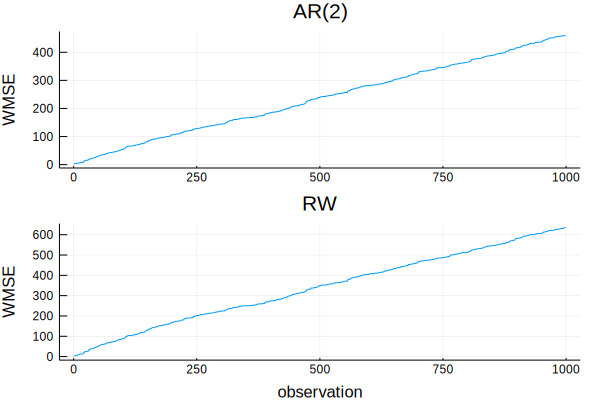

In [685]:
# Plotting
using Plots
pAR = plot(WMSEs, title="AR($ARorder)", ylabel="WMSE", label="")
pRW = plot(WMSEsRW, xlabel="observation", ylabel="WMSE", title="RW", label="")
plot(pAR, pRW, layout=(2,1))

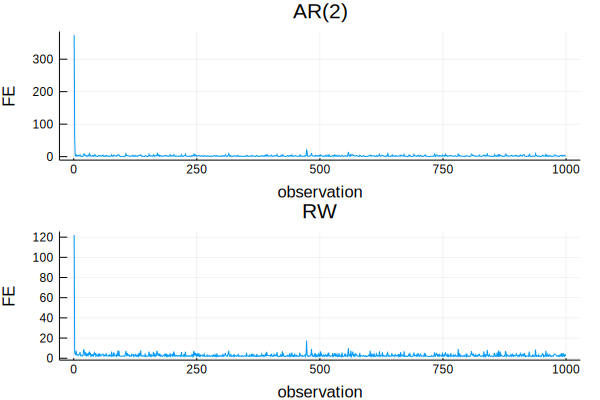

In [686]:
# Free energy
using Plots
pRW = plot(FRW, title="RW", xlabel="observation", ylabel="FE", label="")
pAR = plot(FAR, title="AR($ARorder)", xlabel="observation", ylabel="FE", label="")
plot(pAR, pRW, layout=(2,1))

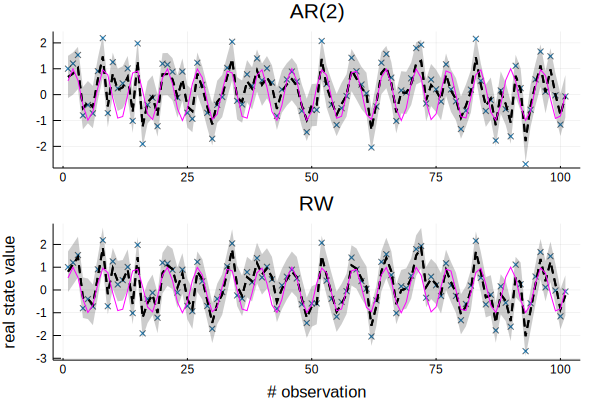

In [687]:
from = 300
upto = 400 # limit for building a graph 
scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in precisionsRW[1:end]] # variances of estimated state
scatter(noise[from:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([meansRW[from:upto], meansRW[from:upto]], fillrange=[meansRW[from:upto] -
      scale .* sqrt.(v_x[from:upto]), meansRW[from:upto] +
      scale .* sqrt.(v_x[from:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(realRW[from:upto], color = :magenta, linewidth = 1.0, label="real state")
pRW = plot!(xlabel="# observation", ylabel="real state value", title="RW")


v_x = [v_x[1]^-1 for v_x in precisionsAR[1:end]] # variances of estimated state
scatter(noise[from:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([meansAR[from:upto], meansAR[from:upto]], fillrange=[meansAR[from:upto] -
      scale .* sqrt.(v_x[from:upto]), meansAR[from:upto] +
      scale .* sqrt.(v_x[from:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(realAR[from:upto], color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(title="AR($ARorder)", legend=false)

plot(pAR, pRW, layout=(2,1), legend=false)

In [688]:
sum(WMSEs)

234706.42373429003

In [689]:
sum(WMSEsRW)

338308.8104597347

In [690]:
sum(FAR)

2836.266580150881

In [691]:
sum(FRW)

2955.7904848734124